| | |
| --- | --- |
| **Author** | Alessio Spurio Mancini |
| **email** | a.spuriomancini@ucl.ac.uk |

<div align="center"><img src='https://drive.google.com/uc?id=1KTafFIJzWQTBdtdd6xrI7OszfhpZYkVM' width="400" height="300"></div>

This notebook can also be run on Colab [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1TZI15JEl0LvSyfoY812TkxueyU72nMGv?usp=sharing)

---
---
# **INTRODUCTION**
---
---

In this notebook we will explore the main features of the emulators for cosmological power spectra implemented in the ``CosmoPower`` class ``cosmopower_PCAplusNN``. We will consider the example of emulating CMB TE power spectra.

**Note 1**: there is no fundamental difference in the way ``cosmopower_PCAplusNN`` works for CMB and $P(k)$ power spectra. The internal workings of the emulator are the same and the way one obtains predictions from the emulator also does not change. Hence, if you have a ``cosmopower_PCAplusNN`` emulator for the matter power spectrum, you can just run this notebook to explore its features.

**Note 2**: similarly, there is no fundamental difference between different types of CMB power spectra (TT,TE,EE,PP) or linear/non linear $P(k)$. In this notebook we will consider examples involving CMB _TE_ power spectra, but the same syntax can be used for all types of spectra emulated with ``cosmopower_PCAplusNN``.

---
---
# **PRELIMINARY OPERATIONS** 
---
---

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, clear_output

2021-12-10 13:25:42.731552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alessio/Documenti/Projects/seismo/raytrace/MultiNest/lib/
2021-12-10 13:25:42.731579: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We will set the random seed in this notebook, for reproducibility of results. 

In [2]:
# setting the seed for reproducibility
np.random.seed(1)
tf.random.set_seed(2)

---
---
# **``cosmopower_PCAplusNN``**
---
---

A ``cosmopower_PCAplusNN`` model is a mapping between cosmological parameters and PCA coefficients of (log)-power spectra. 

<img src='https://drive.google.com/uc?id=13Y4HJgHY-wVnsqP4OHR6hyuAfDPQ9i8o'>

Let's consider a pre-trained model emulating Cosmic Microwave Background temperature-polarization (TE) power spectra. In the ``CosmoPower`` repository we can find an example of such a pre-trained model in the [trained_models](https://github.com/alessiospuriomancini/cosmopower/blob/main/cosmopower/trained_models) folder ([cmb_TE_PCAplusNN.pkl](https://github.com/alessiospuriomancini/cosmopower/blob/main/cosmopower/trained_models/CMB/CP_paper/cmb_TE_PCAplusNN.pkl)).

## **Loading a saved model**

\Loading a saved ``cosmopower_PCAplusNN`` model is as simple as instantiating a ``cosmopower_PCAplusNN`` instance with:

- the attribute ``restore`` set to ``True`` and

- the attribute ``restore_filename`` pointing to the ``.pkl`` file where the model is saved (_without_ the `.pkl` suffix).

In [3]:
import os
ipynb_path = os.path.dirname(os.path.realpath("__file__"))

In [4]:
import cosmopower as cp

# load pre-trained NN model: maps cosmological parameters to CMB TE C_ell
cp_pca_nn = cp.cosmopower_PCAplusNN(restore=True, 
                                    restore_filename=os.path.join(ipynb_path, '../../cosmopower/trained_models/CP_paper/CMB/cmb_TE_PCAplusNN'))

2021-12-10 13:25:45.255269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alessio/Documenti/Projects/seismo/raytrace/MultiNest/lib/
2021-12-10 13:25:45.255302: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-10 13:25:45.255324: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alessio-XPS-13-9360): /proc/driver/nvidia/version does not exist
2021-12-10 13:25:45.255519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Exploring the model features**

Now that the model is loaded, we can explore some its features. First, let's see what are the parameters that the emulator was trained on:

In [5]:
print('emulator parameters: ', cp_pca_nn.parameters)

emulator parameters:  ListWrapper(['omega_b', 'omega_cdm', 'h', 'tau_reio', 'n_s', 'ln10^{10}A_s'])


Next, let's see how the emulator samples the mutipoles $\ell$ for this CMB case:

In [6]:
print('sampled multipoles: ', cp_pca_nn.modes)
print('number of multipoles: ', cp_pca_nn.n_modes)

sampled multipoles:  [   2    3    4 ... 2506 2507 2508]
number of multipoles:  2507


We can also have a look at how many PCA coefficients the emulator uses to compress the spectra:

In [7]:
print('number of PCA coefficients: ', cp_pca_nn.n_pcas)

number of PCA coefficients:  512


The model is a neural network mapping 6 parameters into 512 PCA coefficients. The PCA compression can be inverted to return a prediction for a spectrum sampled at 2507 multipoles. 

Now Let's find out the internal architecture of the model:

In [8]:
print('hidden layers: ', cp_pca_nn.n_hidden)

hidden layers:  ListWrapper([512, 512, 512, 512])


The model has 4 hidden layers, each with 512 nodes.

## **Obtaining predictions**

Now let's explore how ``cosmopower_PCAplusNN`` produces power spectra predictions for a given set of input parameters. All ``CosmoPower`` models take in input a Python ``dict`` of parameters, for example:

In [9]:
# create a dict of cosmological parameters
params = {'omega_b': [0.0225],
          'omega_cdm': [0.113],
          'h': [0.7],
          'tau_reio': [0.055],
          'n_s': [0.96],
          'ln10^{10}A_s': [3.07],
          }

The reason for using input dictionaries is that the user does not need to be concerned with ordering the input parameters. 

The loaded model is an emulator of power spectra, not log-power spectra. 

Training the model on the logarithm of thte power spectra is always recommended, as it reduces the dynamic range to be learnt. However, in the case of TE spectra it is not possible to take the logarithm of the spectra.

Therefore, a forward pass of the input parameters on the trained network (with the method ``predictions_np``) would result in a prediction for the power spectrum directly (not for the log-power spectrum):

In [10]:
# predictions (= forward pass through the network)
spectrum_cosmopower_PCAplusNN = cp_pca_nn.predictions_np(params)

## **COMPARING WITH ``CLASS``**

Let's compare the prediction for the TE power spectrum from ``CosmoPower`` with that from the Boltzmann code [Class](https://arxiv.org/abs/1104.2933). We first need to clone the CLASS repository, compile and install the code:

In [11]:
!pip install cython
!git clone https://github.com/lesgourg/class_public
%cd class_public
!make clean
!make
%cd python 
!python setup.py build
!python setup.py install 

Cloning into 'class_public'...
remote: Enumerating objects: 23412, done.
remote: Counting objects: 100% (1802/1802), done.
remote: Compressing objects: 100% (680/680), done.
remote: Total 23412 (delta 1082), reused 1739 (delta 1049), pack-reused 21610
Ricezione degli oggetti: 100% (23412/23412), 647.02 MiB | 13.11 MiB/s, done.
Risoluzione dei delta: 100% (15003/15003), done.
Checking connectivity... fatto.
/home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public
if ! [ -e /home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/build ]; then mkdir /home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/build ; mkdir /home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/build/lib; fi;
touch build/.base
rm -rf /home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/build;

cd /home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/build;gcc -O3 -fopenmp -g -fPIC -D__CLASSDIR__='"/home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public"' -DHYREC -I../include -I../external/RecfastCLASS -I../external/heating -I../external/HyRec2020 -c ../source/transfer.c -o transfer.o
cd /home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/build;gcc -O3 -fopenmp -g -fPIC -D__CLASSDIR__='"/home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public"' -DHYREC -I../include -I../external/RecfastCLASS -I../external/heating -I../external/HyRec2020 -c ../source/harmonic.c -o harmonic.o
cd /home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/build;gcc -O3 -fopenmp -g -fPIC -D__CLASSDIR__='"/home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started

building 'classy' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/home
creating build/temp.linux-x86_64-3.7/home/alessio
creating build/temp.linux-x86_64-3.7/home/alessio/Documenti
creating build/temp.linux-x86_64-3.7/home/alessio/Documenti/Projects
creating build/temp.linux-x86_64-3.7/home/alessio/Documenti/Projects/cosmopower_public
creating build/temp.linux-x86_64-3.7/home/alessio/Documenti/Projects/cosmopower_public/notebooks
creating build/temp.linux-x86_64-3.7/home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks
creating build/temp.linux-x86_64-3.7/home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public
creating build/temp.linux-x86_64-3.7/home/alessio/Documenti/Projects/cosmopower_public/notebooks/getting_started_notebooks/class_public/python
gcc -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/alessio/anaconda2/envs/cp/lib/

The call to ``Class`` to obtain the same power spectrum prediction obtained from ``CosmoPower`` is as follows:

In [12]:
from classy import Class

cosmo = Class()

# Define cosmology (what is not specified will be set to CLASS default parameters)
params = {'output': 'tCl pCl lCl',
          'l_max_scalars':2508,
          'non linear': 'hmcode',
          'nonlinear_min_k_max': 20,
          'lensing': 'yes',
          'N_ncdm' : 0,
          'N_eff' : 3.046,
          'omega_b': 0.0225,
          'omega_cdm': 0.113,
          'h': 0.7,
          'tau_reio': 0.055,
          'n_s': 0.96,
          'ln10^{10}A_s': 3.07,
          }

cosmo.set(params)
cosmo.compute()
cls = cosmo.lensed_cl(lmax=2508)
spectrum_class = cls['te'][2:]
cosmo.struct_cleanup()
cosmo.empty()

Now let's plot a comparison between the ``CosmoPower`` and ``Class`` predictions:

In [13]:
ell_modes = cp_pca_nn.modes

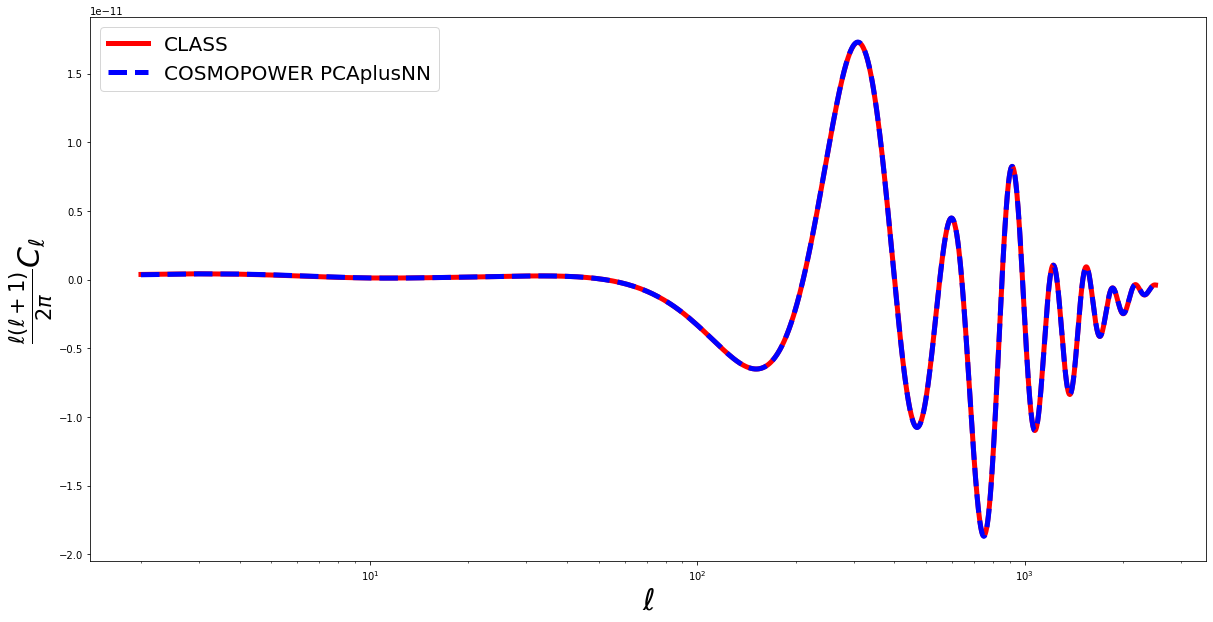

In [14]:
fig = plt.figure(figsize=(20,10))
true = spectrum_class*ell_modes*(ell_modes+1)/(2.*np.pi)
pred = spectrum_cosmopower_PCAplusNN[0]*ell_modes*(ell_modes+1)/(2.*np.pi)
plt.semilogx(ell_modes, true, 'red', label = 'CLASS', linewidth=5)
plt.semilogx(ell_modes, pred, 'blue', label = 'COSMOPOWER PCAplusNN', linewidth=5, linestyle='--')
plt.xlabel('$\ell$', fontsize='30')
plt.ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$', fontsize='30')
plt.legend(fontsize=20)

## **BATCH PREDICTIONS**

So far we considered predictions for a single set of input parameters. However, to fully harvest the computational power of neural networks, it is often convenient to consider _batch_ predictions for multiple sets of input parameters. These can be easily obtained from ``cosmopower_PCAplusNN`` by feeding the emulator with a ``dict`` of ``np.arrays`` of parameters. For example, let's create 10 random sets of cosmological parameters:

In [15]:
omega_b = np.random.uniform(low=0.01875, high=0.02625, size=(10,))
omega_cdm = np.random.uniform(low=0.05, high=0.255, size=(10,))
h = np.random.uniform(low=0.64, high=0.82, size=(10,))
tau_reio = np.random.uniform(low=0.01, high=0.1, size=(10,))
n_s = np.random.uniform(low=0.84, high=1.1, size=(10,))
lnAs = np.random.uniform(low=1.61, high=3.91, size=(10,))

Now let's collect these 10 sets of cosmological parameters into a ``dict`` of ``np.arrays``:

In [16]:
# create a dict of cosmological parameters
batch_params = {'omega_b': omega_b,
                'omega_cdm': omega_cdm,
                'h': h,
                'tau_reio': tau_reio,
                'n_s': n_s,
                'ln10^{10}A_s': lnAs,
                }

We can now _simultaneously_ obtain predictions for _all_ of the 10 parameter sets. Note that the syntax is unchanged w.r.t. the single-set case! 

In [17]:
# predictions (= forward pass thorugh the network) -> 10^predictions
batch_spectra_cosmopower_PCAplusNN = cp_pca_nn.predictions_np(batch_params)

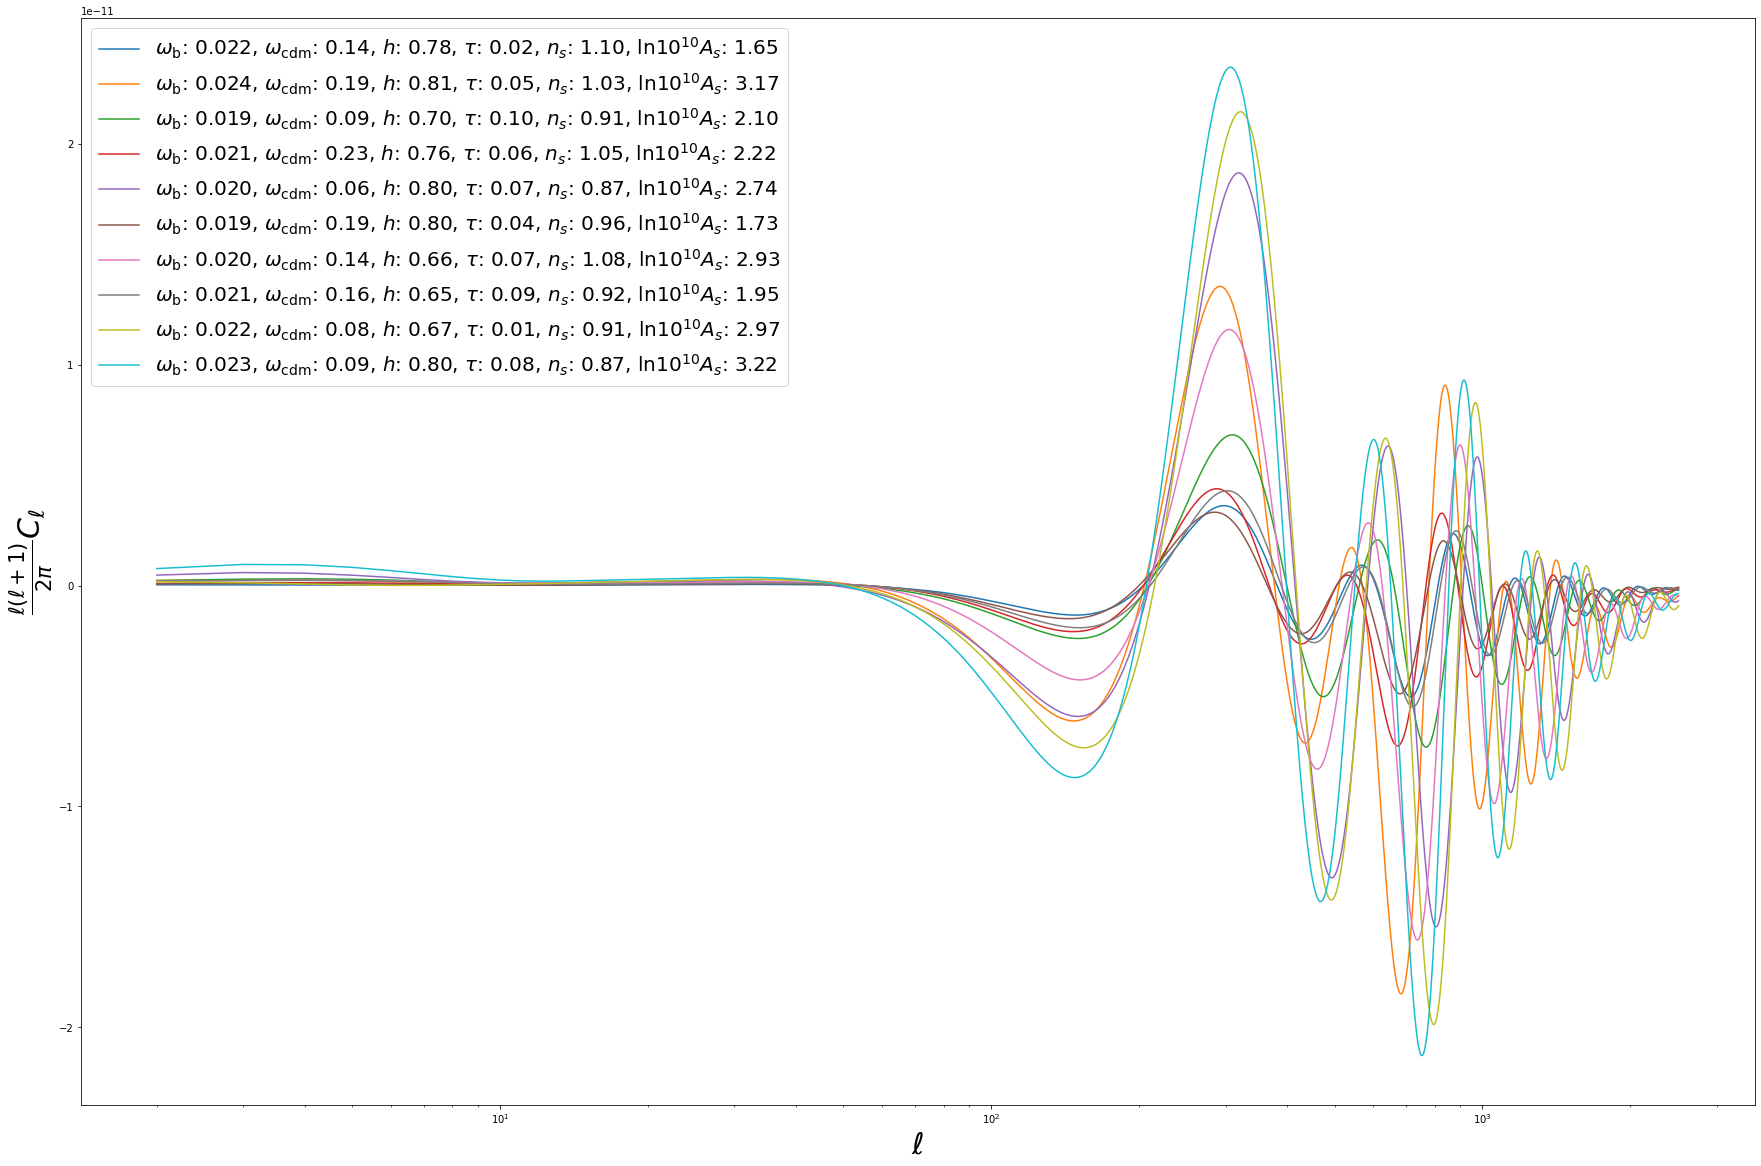

In [18]:
fig = plt.figure(figsize=(30,20))
for i in range(10):
    pred = batch_spectra_cosmopower_PCAplusNN[i]*ell_modes*(ell_modes+1)/(2.*np.pi)
    label = '$\omega_{{\mathrm{{b}}}}$: {:1.3f}, $\omega_{{\mathrm{{cdm}}}}$: {:1.2f}, $h$: {:1.2f}, $\\tau$: {:1.2f}, $n_s$: {:1.2f}, $\\mathrm{{ln}} 10^{{10}}A_s$: {:1.2f}'.format(batch_params['omega_b'][i], batch_params['omega_cdm'][i], batch_params['h'][i], batch_params['tau_reio'][i], batch_params['n_s'][i], batch_params['ln10^{10}A_s'][i])
    plt.semilogx(ell_modes, pred, label = label)
plt.xlabel('$\ell$', fontsize='30')
plt.ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$', fontsize='30')
plt.legend(fontsize=20)